In [1]:
import pygor.load 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data_path = 'C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/contralateral_OT_singleplane/st66/'


Found 6 custom classes in C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes
Class names: ['CenterSurround', 'Core', 'Experiment', 'FullField', 'MovingBars', 'STRF']
Access custom classes using 'from pygor.load import ClassName'


In [2]:
filename = '2024-8-14_x240814_2_4cOT.h5'
data_object = pygor.load.Core(data_path+filename)

C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:64: UserWarning: 'wDataCh0_detrended' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.images = try_fetch(HDF5_file, "wDataCh0_detrended")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:75: UserWarning: 'Positions' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.ipl_depths = try_fetch(HDF5_file, "Positions")
C:\Users\Michael Forsthofer\Coding\pygor\src\pygor\classes\core_data.py:77: UserWarning: 'Snippets0' not found in C:\Users\Michael Forsthofer\OneDrive - University of Sussex\BadenLab\2p-imaging\contralateral_OT_singleplane\st66\2024-8-14_x240814_2_4cOT.h5, setting to np.nan
  self.snippets = try_fetch(HDF5_file, "Snippets0")
C

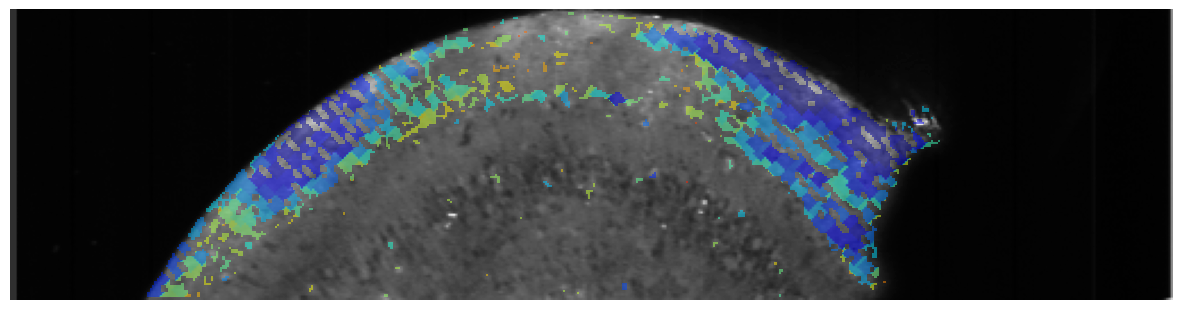

In [3]:
data_object.view_stack_rois(labels=False, figsize_scale=3, func='average_stack')

<b>Find where rois are located</b>

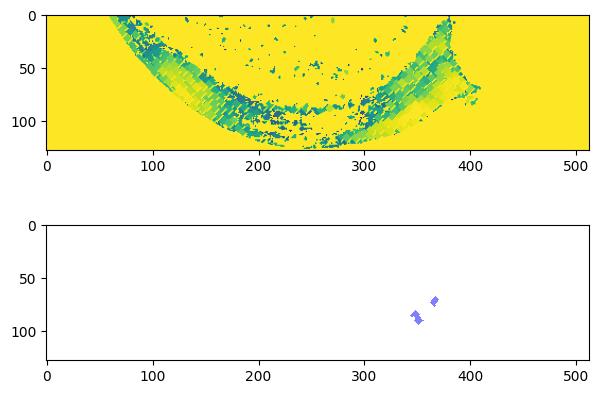

In [4]:
f, ax = plt.subplots(2, 1, figsize=(7, 5))
ax[0].imshow(data_object.rois)

from matplotlib.colors import ListedColormap
data = data_object.rois
values_to_plot = [-1, -5, -46]
mask = np.isin(data, values_to_plot)
cmap = ListedColormap([(0, 0, 1, 0), (0, 0, 1, 0.5)]) 
ax[1].imshow(mask, cmap=cmap, interpolation='none')


<b>Get mean traces</b>

<b>Get stimulus triggers</b>

In [5]:
print(data_object.ms_dur)
print(data_object.frame_hz)
print(len(data_object.triggerstimes_frame))
print(data_object.linedur_s)
print(data_object.trigger_mode)


30802
3.9941205978393555
32
0.001955999992787838
9


In [6]:
def flexible_reshape(array, columns):
    # Calculate the number of elements to keep
    elements_to_keep = (len(array) // columns) * columns
    # Reshape the array
    reshaped_array = array[:elements_to_keep].reshape(-1, columns)
    return reshaped_array

triggertimes_ms = (data_object.triggerstimes_frame-data_object.triggerstimes_frame[0])/data_object.frame_hz/data_object.linedur_s

mean_triggertimes_ms = flexible_reshape(triggertimes_ms, data_object.trigger_mode)
mean_triggertimes_ms = np.mean(mean_triggertimes_ms, axis=0)-np.mean(mean_triggertimes_ms, axis=0)[0]

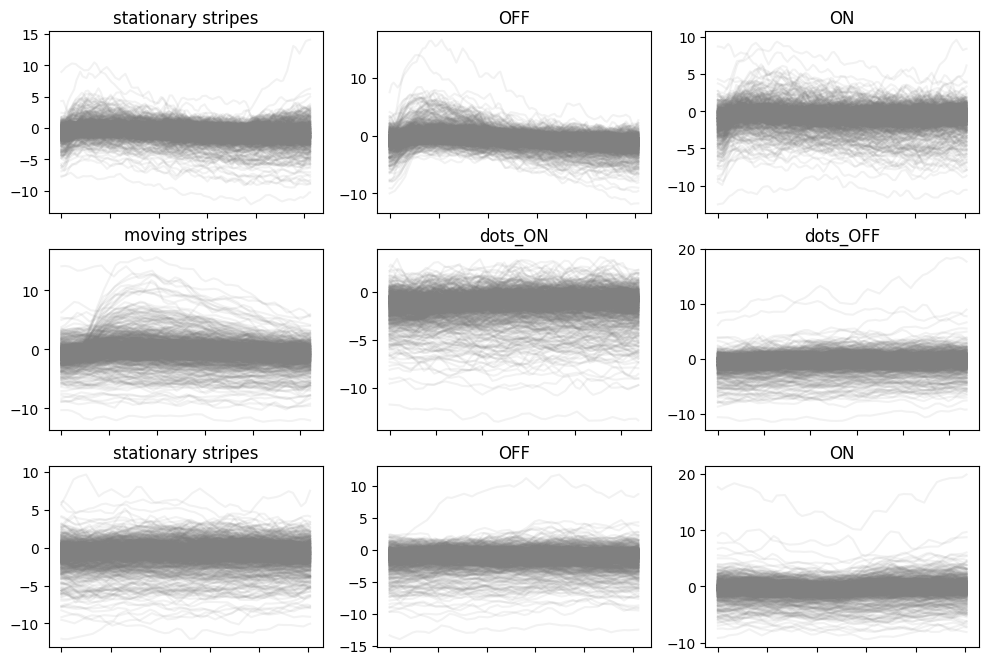

In [7]:
traces = data_object.averages
mean_triggertimes_extended = np.round(np.append(mean_triggertimes_ms, len(traces.transpose()))).astype(int)
stimtypes = ['stationary stripes','moving stripes','stationary stripes','OFF','dots_ON','OFF','ON','dots_OFF','ON',]
stim_responses = []

f, ax = plt.subplots(3, 3, figsize=(12, 8))

for idx, i in enumerate(mean_triggertimes_extended[:-1]):
    stim_responses.append(traces[:,i:mean_triggertimes_extended[idx+1]].transpose())  


for idx, i in enumerate(stim_responses):
    ax[idx%3, idx//3].plot(i, color='gray', alpha=0.1)  
    ax[idx%3, idx//3].set_xticklabels([])
    ax[idx%3, idx//3].set_title(stimtypes[idx])
    #ax[idx%3, idx//3].set_ylim(-5, 5)

In [8]:
from sklearn import cluster

stim_clusters = []

for idx, i in enumerate(stim_responses):

    dots_OFF = stim_responses[7]-stim_responses[7][1,:]
    dots_off = dots_OFF.transpose()

    kmeans_data = cluster.KMeans(n_clusters=3, init='k-means++', random_state=0)

    kmeans_data.fit(dots_off)

    labels = kmeans_data.labels_


c:\miniconda3\envs\PYGOR-TIMESERIES\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\miniconda3\envs\PYGOR-TIMESERIES\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


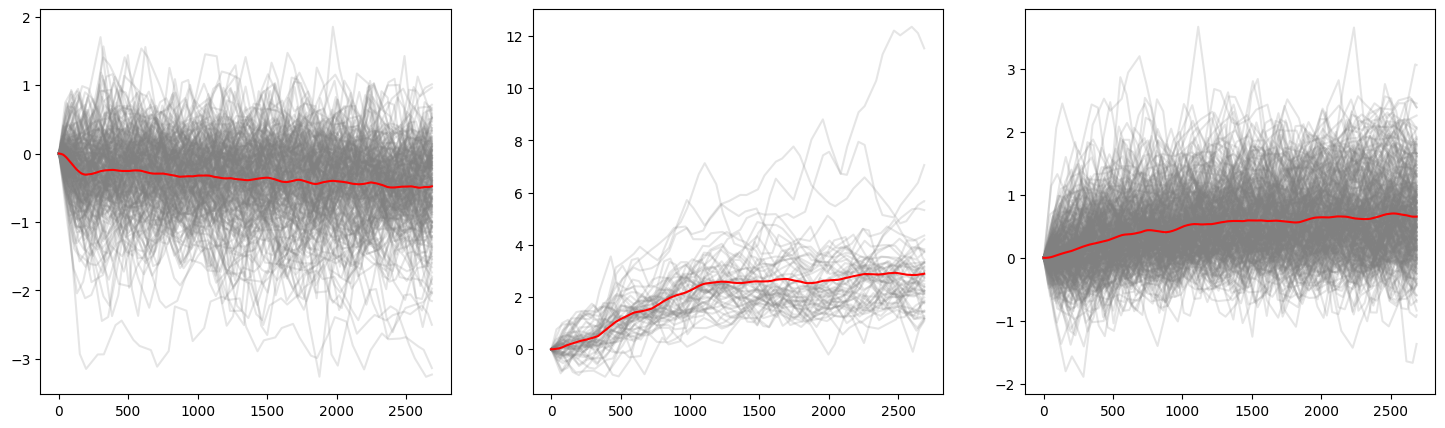

In [9]:
f, ax = plt.subplots(1, 3, figsize=(18, 5))
for idx, i in enumerate(np.unique(labels)):
    ax[idx].plot(dots_off[labels==i,:].transpose(), color='gray', alpha=0.2)
    ax[idx].plot(np.mean(dots_off[labels==i,:].transpose(), axis=1), color='r')

Plot rois by cluster allocation

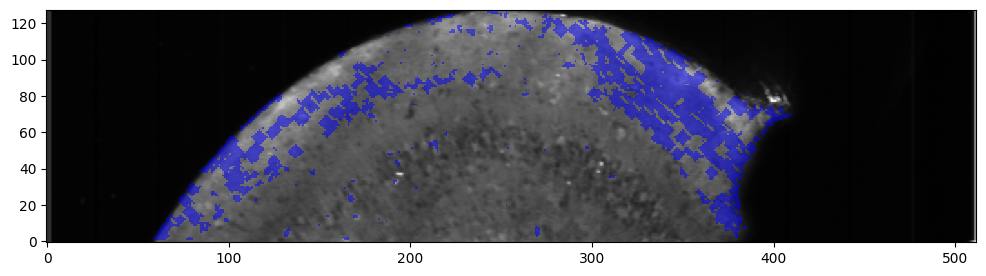

In [10]:
from matplotlib.colors import ListedColormap
f, ax = plt.subplots(1, 1, figsize=(12, 4))

rois = data_object.rois
found_rois = (np.where(labels==2)[0]+1)*-1
mask = np.isin(data, found_rois)
cmap = ListedColormap([(0, 0, 1, 0), (0, 0, 1, 0.5)]) 
ax.imshow(data_object.average_stack, cmap = "Greys_r", origin = "lower")
ax.imshow(mask, cmap=cmap, interpolation='none', origin="lower")




Calculate how many clusters are suitable for k-means

In [11]:
n_clusters_list = []


#find out hwo many clusters we need for each response section
for iter_responses in stim_responses:
    i_responses = iter_responses-np.mean(iter_responses, axis=0)
    cost = []
    n_clust = 15
    for i in range(1, n_clust):
        kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans_data.fit(i_responses.transpose())
        cost.append(kmeans_data.inertia_)

    n_clusters = len(np.where(abs(np.diff(np.diff(cost)))/abs(np.diff(np.diff(cost)))[-1]>5)[0])
    n_clusters_list.append(n_clusters)

In [12]:
n_clusters_list

[2, 11, 6, 5, 3, 4, 1, 6, 5]

In [13]:
cluster_labels = []
#get the clusters for each response
for idx, i in enumerate(n_clusters_list):
    i_responses = stim_responses[idx]-np.mean(stim_responses[idx], axis=0)
    kmeans_data = cluster.KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans_data.fit(i_responses.transpose())
    cluster_labels.append(kmeans_data.labels_)


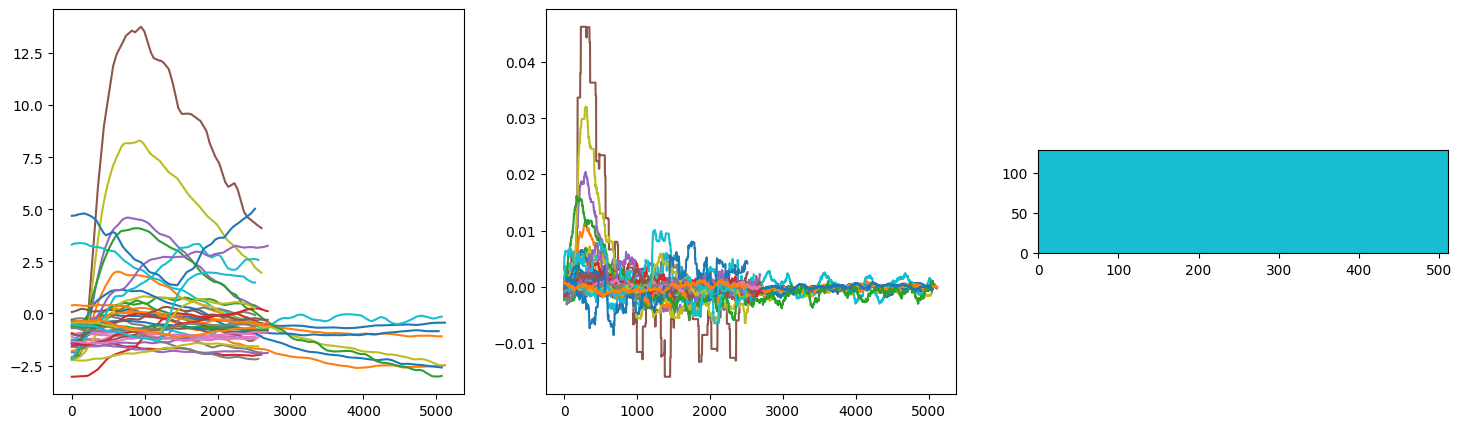

In [14]:
min_traces_per_cluster = 3
colors = plt.cm.tab10(np.linspace(0, 1, 9))
#cmap = ListedColormap([(0, 0, 1, 0), (0, 0, 1, 0.5)]) 
#for each response section, find the clusters that have a positive response to the stimulus
f, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[2].imshow(data_object.average_stack, cmap = "Greys_r", origin = "lower")
stim_responsive_clusters = []
for idx_stim, cur_label_array in enumerate(cluster_labels):
    for idx_label, cur_label in enumerate(np.unique(cur_label_array)):
        cur_cluster_mean = np.mean(stim_responses[idx_stim][:,cur_label_array==cur_label], axis=1)
        if idx_stim>-1:
            if np.shape(stim_responses[idx_stim][:,cur_label_array==cur_label])[1]>=min_traces_per_cluster:
                found_rois = (np.where(cur_label_array==cur_label)[0]+1)*-1
                mask = np.isin(data, found_rois)
                ax[0].plot(cur_cluster_mean)
                ax[1].plot(np.diff(cur_cluster_mean))
                cmap = ListedColormap([colors[idx_stim]])
                ax[2].imshow(mask, cmap=cmap, interpolation='none', origin="lower")

C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_14960\1175344181.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 9))
C:\Users\Michael Forsthofer\AppData\Local\Temp\ipykernel_14960\1175344181.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  clustcolors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))


0
0
0
0
0
0
1
2


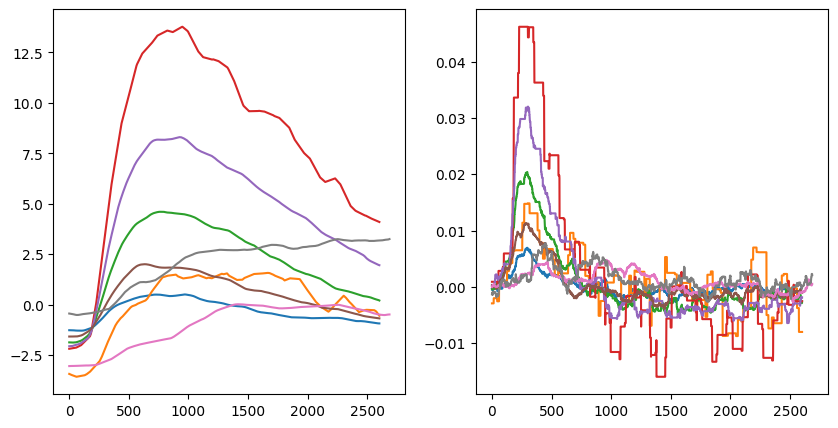

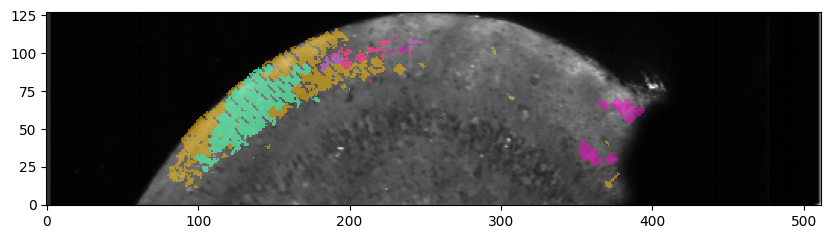

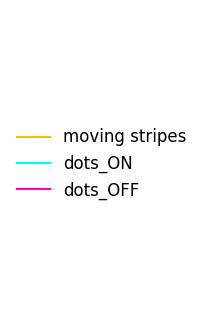

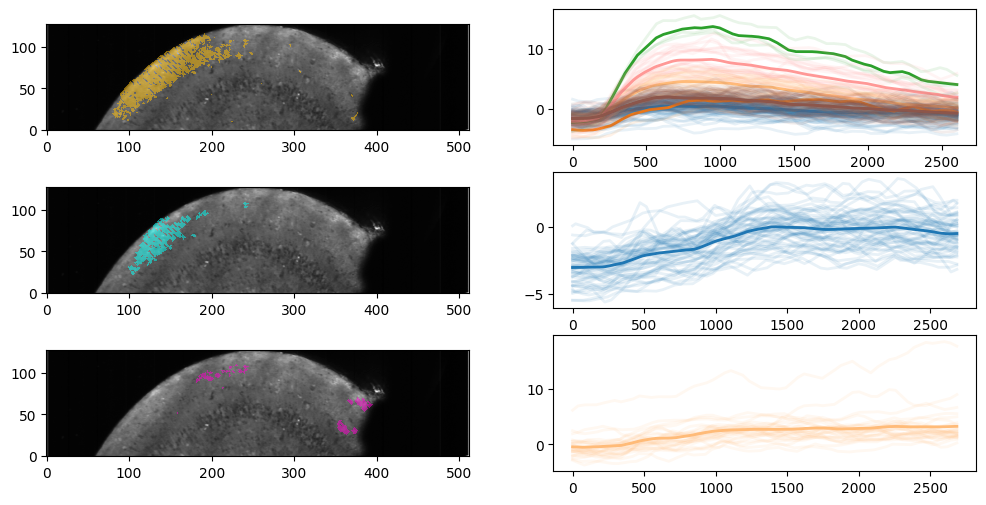

In [87]:
min_traces_per_cluster = 2
stimuli_to_plot = ['moving stripes', 'dots_ON', 'dots_OFF']
#stimuli_to_plot = ['moving stripes']
colors = plt.cm.get_cmap('hsv')(np.linspace(0, 1, 9))
clustcolors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, 20))
f, ax = plt.subplots(1, 2, figsize=(10, 5))
f2, ax2 = plt.subplots(1, 1, figsize=(10, 5))
f3, ax3 = plt.subplots(1, 1, figsize=(2, 4))
f4, ax4 = plt.subplots(len(stimuli_to_plot), 2, figsize=(12,6))

for background_image in range(len(stimuli_to_plot)):
    ax4[background_image, 0].imshow(data_object.average_stack, cmap="Greys_r", origin="lower")

handles_labels = {}
ax2.imshow(data_object.average_stack, cmap="Greys_r", origin="lower")
stim_responsive_clusters = []
for idx_stim, cur_label_array in enumerate(cluster_labels):
    for idx_label, cur_label in enumerate(np.unique(cur_label_array)):
        cur_cluster_mean = np.mean(stim_responses[idx_stim][:, cur_label_array == cur_label], axis=1)
        if idx_stim > -1:
            if np.shape(stim_responses[idx_stim][:, cur_label_array == cur_label])[1] >= min_traces_per_cluster:
                if np.max(np.diff(cur_cluster_mean) > 0.004):
                    if stimtypes[idx_stim] in stimuli_to_plot:    
                        found_rois = (np.where(cur_label_array == cur_label)[0] + 1) * -1
                        mask = np.isin(data, found_rois)

                        # Plot cluster means and differences
                        ax[0].plot(cur_cluster_mean)
                        ax[1].plot(np.diff(cur_cluster_mean))

                        # Create a colored overlay where only the mask part is colored
                        color = colors[idx_stim]  # Select the color for the current idx_stim
                        clustcolor=clustcolors[cur_label]
                        colored_mask = np.zeros((*mask.shape, 4))  # Create an RGBA image (shape + 4 for RGBA)
                        clust_mask = np.zeros((*mask.shape, 4))
                        if idx_stim not in handles_labels:
                            ax3.plot(0, 0, color=color, label=stimtypes[idx_stim])
                            handles_labels[idx_stim] = f'Stim {idx_stim}'  # Track the label
                        
                        # Apply color only to the ROI parts of the mask
                        colored_mask[mask] = np.array([*color[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5
                        clust_mask[mask] = np.array([*clustcolor[:3], 0.5])  # Use the RGB values from the colormap and set alpha to 0.5

                        # Plot the colored mask over the background
                        ax2.imshow(colored_mask, interpolation='none', origin="lower")
                        try:
                            index_of_dots_ON = stimuli_to_plot.index(stimtypes[idx_stim])
                            print(str(index_of_dots_ON))
                            ax4[index_of_dots_ON, 0].imshow(colored_mask, interpolation='none', origin="lower")
                            ax4[index_of_dots_ON, 1].plot(cur_cluster_mean, color=clustcolors[cur_label], linewidth=2)
                            ax4[index_of_dots_ON, 1].plot(stim_responses[idx_stim][:, cur_label_array == cur_label], color=clustcolors[cur_label], alpha=0.1, linewidth=2)
                        except:
                            print('stim not in list')
                        
ax3.axis('off')

# Make the legend take up the whole figure
ax3.legend(loc='center', bbox_to_anchor=(0.5, 0.5), fontsize=12, ncol=1, frameon=False)



In [70]:
colors[cur_label]

array([0.        , 1.        , 0.96470316, 1.        ])

Try other clustering methods: self-organizing maps (SOM)

In [17]:
40 119 200
60 140 221
# # Algorithms
# from minisom import MiniSom
# import pickle

# def plot_som_series_averaged_center(som_x, som_y, win_map):
#     fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
#     fig.suptitle('Clusters')
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 for series in win_map[cluster]:
#                     axs[cluster].plot(series,c="gray",alpha=0.5) 
#                 axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
#             cluster_number = x*som_y+y+1
#             axs[cluster].set_title(f"Cluster {cluster_number}")


# def get_som_series_averaged_center(som_x, som_y, win_map):
#     clustered_traces = []
#     cluster_averages = []
#     for x in range(som_x):
#         for y in range(som_y):
#             cluster = (x,y)
#             if cluster in win_map.keys():
#                 clustered_traces.append(np.vstack(win_map[cluster]))
#                 cluster_averages.append(np.average(np.vstack(win_map[cluster]),axis=0))
#     return clustered_traces, cluster_averages

# som_x = som_y = 3 #math.ceil(math.sqrt(math.sqrt(len(traces))))
# traces = dots_OFF.transpose()
# som = MiniSom(som_x, som_y,len(traces[0]), sigma=0.5, learning_rate = 0.2, neighborhood_function='mexican_hat', random_seed=10)
# som.random_weights_init(traces)
# som.train(traces, 50000)

# #save the SOM
# with open('C:/Users/Michael Forsthofer/OneDrive - University of Sussex/BadenLab/2p-imaging/clustering analysis/mexicamhat_sigma1.5_randomseed10_lr0.1', 'wb') as outfile:
#     pickle.dump(som, outfile)

# win_map = som.win_map(traces)

# plot_som_series_averaged_center(som_x, som_y, win_map)

# clustered_traces, cluster_averages = get_som_series_averaged_center(som_x, som_y, win_map)

# f, ax = plt.subplots(len(cluster_averages), 1, figsize=(7, 30))
# for i in range(len(cluster_averages)):
#     ax[i].plot(clustered_traces[i], color='r')
#     ax[i].plot(cluster_averages[i], color='r')
#     ax[i].set_xticklabels([])
#     ax[i].set_yticklabels([])
#     ax[i].set_xlim(0, len(cluster_averages[i]))
#     ax[i].spines['top'].set_visible(False)
#     ax[i].spines['right'].set_visible(False)
#     ax[i].spines['bottom'].set_visible(False)
#     ax[i].spines['left'].set_visible(False)

# ax.tight_layout()


SyntaxError: invalid syntax (1967519152.py, line 1)